# Using `toffee` as a spatial data structure for fast extraction of SWATH-MS data

Analysis of SWATH-MS data often requires us to slice the data through both the abscissa or the ordinate. Many traditional data structures for sparse data like this offer fast searching in one direction, but not both. However, by defining the data as a point cloud, we can insert this into a spatial data structure such as an [R-Tree](https://en.wikipedia.org/wiki/R-tree) and enable arbitrary searches of the data using axis-aligned boxes. Moreover, as the point cloud is defined in integer terms, we gain performance while also avoiding issues of binary comparisons of floating point numbers.

In `toffee` we have implemented a [boost::rtree](http://www.boost.org/doc/libs/1_65_1/libs/geometry/doc/html/geometry/reference/spatial_indexes/boost__geometry__index__rtree.html) index in C++; searching the R-Tree through the C++ library can return sparse or dense [Eigen](https://eigen.tuxfamily.org/) matrices that are exposed to python such that data can be manipulated as [numpy.ndarray](http://www.numpy.org/) or [scipy.sparse.csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html).

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import scipy
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import toffee
sns.set()
sns.set_color_codes()

In [2]:
toffee.__version__

'0.12.18'

## Opening a `toffee` file

Opening a `toffee` file is typically the most computationally expensive operation as the data must be loaded from the file into the RTree search index.

In [3]:
base_dir = os.environ.get('DIA_TEST_DATA_REPO', None)
assert base_dir is not None
fname = base_dir + '/ProCan90/tof/ProCan90-M03-01.tof'
swath_run = toffee.SwathRun(fname)
ms2_name = toffee.ToffeeWriter.ms2Name(50)

## Accessing summary statistics

From within this spatial search structure, we can gain high performance access to summary statistics such as total ion chromatogram, base peak chromatogram, or total ion spectra

In [4]:
%timeit swath_run.loadSwathMapInMemorySpectrumAccess(ms2_name)
ms1_swath_map = swath_run.loadSwathMapInMemorySpectrumAccess(toffee.ToffeeWriter.MS1_NAME)
ms2_swath_map_050 = swath_run.loadSwathMapInMemorySpectrumAccess(ms2_name)

109 ms ± 2.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Summary plots for ms1


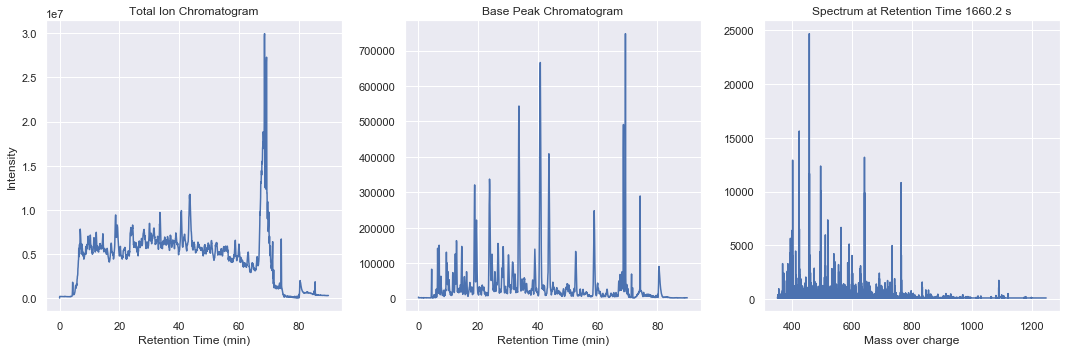

Summary plots for ms2-050


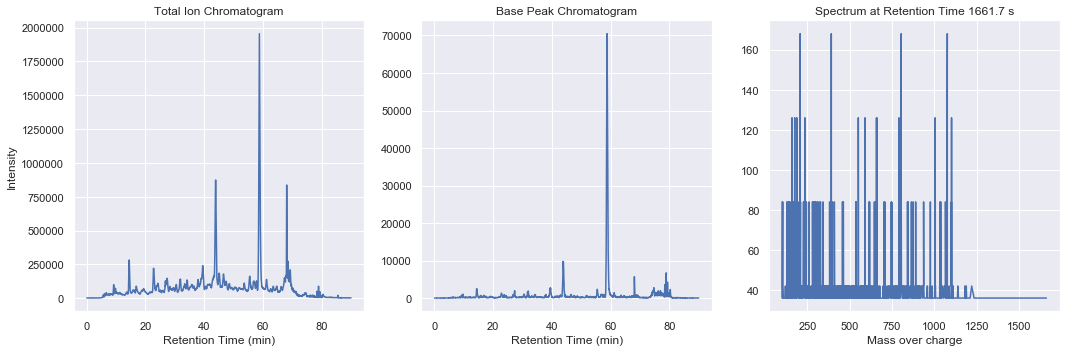

In [5]:
def plot(swath_map):
    print('Summary plots for', swath_map.name())
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))

    chrom = swath_map.totalIonChromatogram()
    ax1.plot(chrom.retentionTime / 60., chrom.intensities)
    ax1.set_title('Total Ion Chromatogram')
    ax1.set_xlabel('Retention Time (min)')
    ax1.set_ylabel('Intensity')

    chrom = swath_map.basePeakChromatogram()
    ax2.plot(chrom.retentionTime / 60., chrom.intensities)
    ax2.set_title('Base Peak Chromatogram')
    ax2.set_xlabel('Retention Time (min)')

    idx = 500
    spectrum = swath_map.spectrumByIndex(idx)
    ax3.plot(spectrum.massOverCharge, spectrum.intensities)
    ax3.set_title(f'Spectrum at Retention Time {swath_map.retentionTime()[idx]:.1F} s')
    ax3.set_xlabel('Mass over charge')

    fig.tight_layout()
    plt.show()
    
plot(ms1_swath_map)
plot(ms2_swath_map_050)

In [6]:
%timeit ms2_swath_map_050.totalIonChromatogram()

943 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%timeit ms2_swath_map_050.basePeakChromatogram()

1.2 ms ± 19.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%timeit ms2_swath_map_050.spectrumByIndex(int(np.random.uniform(0, 1200)))

15.2 µs ± 86.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Extracting Chromatograms

We can also extract specific chromatograms with high performance random access filtering for both mass over charge and retention time ranges.

In [9]:
%timeit swath_run.loadSwathMap(ms2_name)
ms1_swath_map = swath_run.loadSwathMap(toffee.ToffeeWriter.MS1_NAME)
ms2_swath_map_050 = swath_run.loadSwathMap(ms2_name)

534 ms ± 22.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
mz_range = toffee.MassOverChargeRangeWithPPMFullWidth(659.35, 50)
rt_range = toffee.RetentionTimeRange(20 * 60.0, 30 * 60.0)  # between 20 & 30 mins

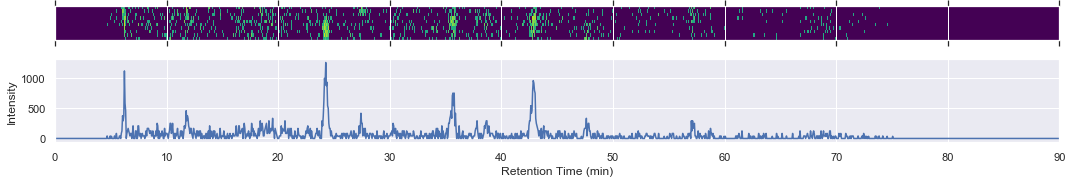

In [11]:
chrom = ms2_swath_map_050.extractedIonChromatogram(mz_range)
xlim = [chrom.retentionTime[0] / 60.0, chrom.retentionTime[-1] / 60.0]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 3), sharex=True)

intensities = np.log10(1 + chrom.intensities.T)
ax1.matshow(intensities, extent=xlim + [0, 3], cmap=plt.cm.viridis)
ax1.set_xlim(xlim)
ax1.set_ylabel('m/z (Da)')
ax1.yaxis.set_visible(False)

ax2.plot(chrom.retentionTime / 60.0, np.sum(chrom.intensities, axis=1))
ax2.set_xlim(xlim)
ax2.set_xlabel('Retention Time (min)')
ax2.set_ylabel('Intensity')

fig.tight_layout()

In [12]:
%timeit ms2_swath_map_050.extractedIonChromatogram(mz_range)
%timeit ms2_swath_map_050.extractedIonChromatogramSparse(mz_range)

63.8 µs ± 5.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
57.6 µs ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [13]:
%timeit ms2_swath_map_050.extractedIonChromatogram(\
    toffee.MassOverChargeRangeWithPPMFullWidth(np.random.uniform(100, 2000), 50)\
    )
%timeit ms2_swath_map_050.extractedIonChromatogramSparse(\
    toffee.MassOverChargeRangeWithPPMFullWidth(np.random.uniform(100, 2000), 50)\
    )

26.1 µs ± 968 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
24.2 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


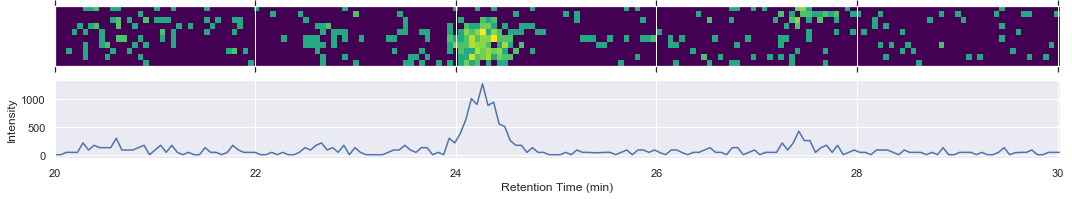

In [14]:
chrom = ms2_swath_map_050.filteredExtractedIonChromatogram(mz_range, rt_range)
xlim = [chrom.retentionTime[0] / 60.0, chrom.retentionTime[-1] / 60.0]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 3), sharex=True)

intensities = np.log10(1 + chrom.intensities.T)
ax1.matshow(intensities, extent=xlim + [0, 0.6], cmap=plt.cm.viridis)
ax1.set_xlim(xlim)
ax1.set_ylabel('m/z (Da)')
ax1.yaxis.set_visible(False)

ax2.plot(chrom.retentionTime / 60.0, np.sum(chrom.intensities, axis=1))
ax2.set_xlim(xlim)
ax2.set_xlabel('Retention Time (min)')
ax2.set_ylabel('Intensity')

fig.tight_layout()

In [15]:
%timeit ms2_swath_map_050.filteredExtractedIonChromatogram(mz_range, rt_range)
%timeit ms2_swath_map_050.filteredExtractedIonChromatogramSparse(mz_range, rt_range)

11.6 µs ± 93.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
10.8 µs ± 61.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [16]:
%timeit ms2_swath_map_050.filteredExtractedIonChromatogram(\
    toffee.MassOverChargeRangeWithPPMFullWidth(np.random.uniform(100, 2000), 50),\
    toffee.RetentionTimeRangeWithPixelHalfWidth(np.random.uniform(20 * 60.0, 70 * 60.0), 50)\
    )
%timeit ms2_swath_map_050.filteredExtractedIonChromatogramSparse(\
    toffee.MassOverChargeRangeWithPPMFullWidth(np.random.uniform(100, 2000), 50),\
    toffee.RetentionTimeRangeWithPixelHalfWidth(np.random.uniform(20 * 60.0, 70 * 60.0), 50)\
    )

13.1 µs ± 1.1 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
12.4 µs ± 890 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
